In [88]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import os

import time
from datetime import datetime, timedelta

import sklearn.metrics as sk_metrics

In [28]:
PATH = './data/'

train_dir = os.path.join(PATH, 'training')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [29]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5075 files belonging to 4 classes.


In [30]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1741 files belonging to 4 classes.


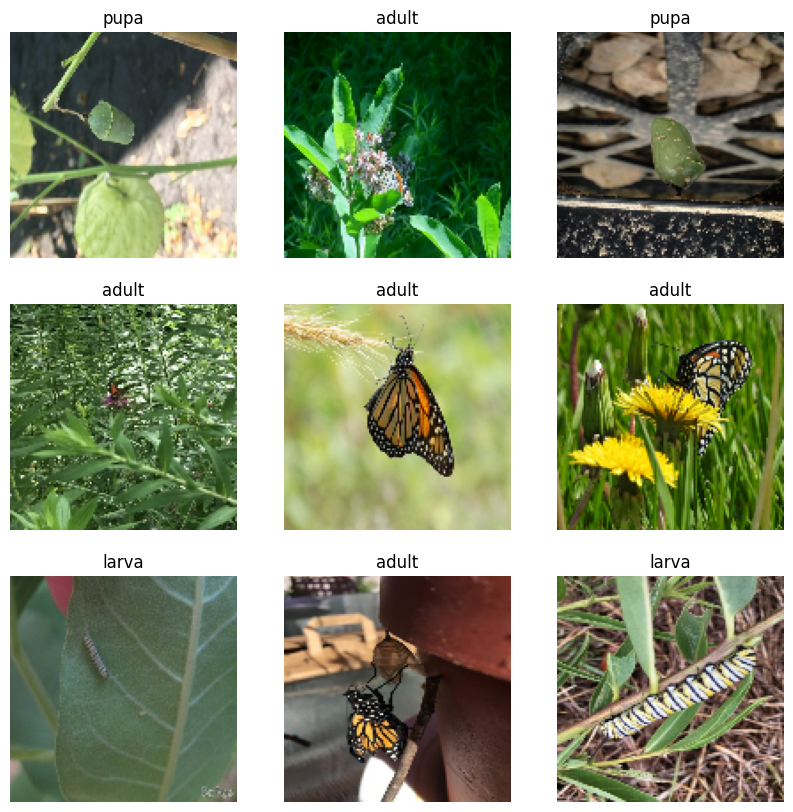

In [31]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
# create a test set from validation
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [33]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 44
Number of test batches: 11


In [34]:
# create buffer for better performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [35]:
# rotate images for training
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [36]:
# rescale pixels from [0,255] to [-1,1]
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [37]:
IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
inception = keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                        weights='imagenet', 
                                                        input_shape=IMG_SHAPE)

In [38]:
for layer in inception.layers[:200]:
    layer.trainable = False

In [39]:
len(inception.layers)

311

In [40]:
num_classes = 4

model = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2),
            inception,
#             tf.keras.layers.Conv2D(32, 3, activation='relu'),
#             tf.keras.layers.MaxPooling2D(),
#             tf.keras.layers.Conv2D(32, 3, activation='relu'),
#             tf.keras.layers.MaxPooling2D(),
#             tf.keras.layers.Conv2D(32, 3, activation='relu'),
#             tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes)
])

In [45]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
)

In [46]:
EPOCHS = 6
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/6
159/159 [==============================] - 91s 518ms/step - loss: 0.4798 - accuracy: 0.8392 - val_loss: 0.4195 - val_accuracy: 0.8927
Epoch 2/6
159/159 [==============================] - 82s 517ms/step - loss: 0.2552 - accuracy: 0.9096 - val_loss: 0.2159 - val_accuracy: 0.9381
Epoch 3/6
159/159 [==============================] - 82s 515ms/step - loss: 0.2107 - accuracy: 0.9265 - val_loss: 0.1165 - val_accuracy: 0.9590
Epoch 4/6
159/159 [==============================] - 82s 518ms/step - loss: 0.1679 - accuracy: 0.9442 - val_loss: 0.1263 - val_accuracy: 0.9568
Epoch 5/6
159/159 [==============================] - 81s 512ms/step - loss: 0.1272 - accuracy: 0.9570 - val_loss: 0.1594 - val_accuracy: 0.9482
Epoch 6/6
159/159 [==============================] - 81s 512ms/step - loss: 0.1164 - accuracy: 0.9628 - val_loss: 0.2376 - val_accuracy: 0.9712


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


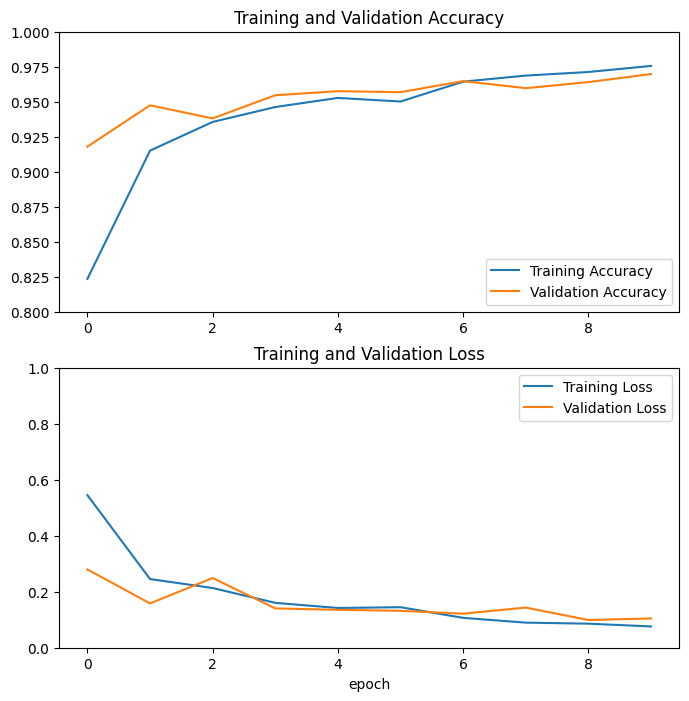

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [47]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 3s 262ms/step - loss: 0.1574 - accuracy: 0.9659
Test accuracy : 0.9659090638160706


In [150]:
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

In [48]:
predictions = model.predict(test_dataset)

11/11 [==============================] - 4s 265ms/step


In [49]:
predicted_label = [np.argmax(tf.nn.softmax(prediction)) for prediction in predictions]

In [56]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=False,
#                                                                  batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1741 files belonging to 4 classes.


In [57]:
predictions = model.predict(validation_dataset)

55/55 [==============================] - 14s 262ms/step


In [58]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

55/55 [==============================] - 14s 257ms/step - loss: 0.2204 - accuracy: 0.9701
Test accuracy : 0.9701321125030518


In [83]:
validation_labels = []
for images, labels in validation_dataset.take(55):
    validation_labels.extend(labels.numpy())

In [85]:
len(validation_labels)

1741

In [62]:
# model.save('models/20230212_inception')

In [65]:
validation_predictions = [np.argmax(prediction) for prediction in predictions]

In [101]:
cm = sk_metrics.confusion_matrix(validation_labels,validation_predictions)

In [102]:
disp = sk_metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                        display_labels = class_names)

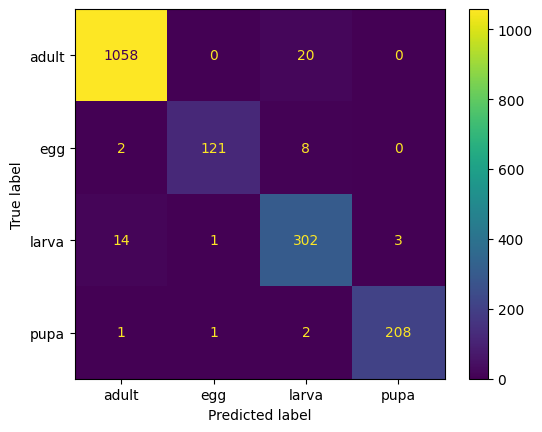

In [103]:
disp.plot()
plt.show()